## This notebook tests experimental features that will likely change.

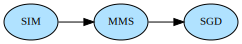

In [1]:
from lale.lib.rasl import SimpleImputer as SIM
from lale.lib.rasl import MinMaxScaler as MMS
from lale.lib.sklearn import SGDClassifier as SGD
from lale.lib.sklearn import RandomForestClassifier as RFC

def fresh_pipeline(final_est="sgd"):  #create new to guarantee fresh state after earlier fit/partial_fit, if any
    assert final_est in ["sgd", "rfc"]
    return (
        SIM(strategy="mean")
        >> MMS()
        >> (SGD(random_state=42) if final_est == "sgd" else RFC(random_state=42))
    )

fresh_pipeline().visualize()

In [2]:
from lale.lib.rasl import is_associative, is_incremental, PrioBatch, PrioStep, PrioResourceAware
from lale.lib.rasl import mockup_data_loader, fit_with_batches, cross_val_score
from sklearn.model_selection import KFold

assert is_associative(SIM)
assert is_associative(MMS)
assert is_incremental(SGD)
assert not is_incremental(RFC)

In [3]:
import lale.datasets.openml
import math
import pandas as pd
from lale.lib.lale import Project

(raw_train_X, train_y), (raw_test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)
project = Project(columns={"type": "number"}).fit(raw_train_X)
train_X, test_X = project.transform(raw_train_X), project.transform(raw_test_X)
unique_class_labels = list(train_y.unique())
print(f"unique_class_labels {unique_class_labels}")
train_data_space = train_X.memory_usage().sum() + train_y.memory_usage()
print(f"train_data_space {train_data_space}")
pd.set_option('display.max_rows', 6)
pd.concat([test_y, test_X], axis=1)

/home/hirzel/python3.7venv/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


unique_class_labels ['good', 'bad']
train_data_space 53600


,class,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
993,good,36.0,3959.0,4.0,3.0,30.0,1.0,1.0
859,good,9.0,3577.0,1.0,2.0,26.0,1.0,2.0
298,good,18.0,2515.0,3.0,4.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...
503,bad,24.0,1216.0,4.0,4.0,38.0,2.0,2.0
263,good,12.0,2748.0,2.0,4.0,57.0,3.0,1.0
808,good,42.0,9283.0,1.0,2.0,55.0,1.0,1.0


### Example: no RASL

In [4]:
import lale.lib.rasl

accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

print(f"majority class {len(test_y[test_y == 'good']) / len(test_y):.3%}")
trained = fresh_pipeline().fit(train_X, train_y)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

majority class 70.909%
accuracy 70.909%


### Example: no batching, no cross-validation
- starting point
- behavior equivalent to sklearn
- purposely setting max_resident too low to demonstrate cache warnings

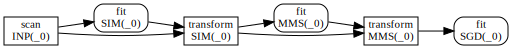

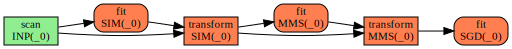

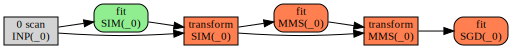

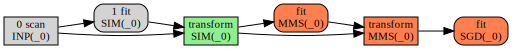

aborted spill of batch -1__0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


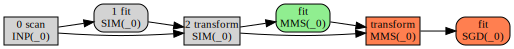

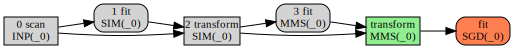

aborted spill of batch 0__0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


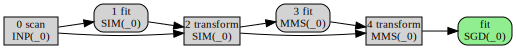

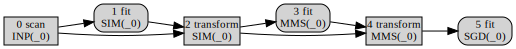

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 107200,
    "max_resident": 53600,
    "train_count": 3,
    "apply_count": 3,
    "metric_count": 0,
    "train_time": 0.06159186363220215,
    "apply_time": 0.06452298164367676,
    "metric_time": 0,
    "critical_count": 6,
    "critical_time": 0.1261148452758789,
}
accuracy 70.909%


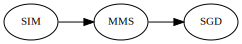

In [5]:
n_batches = 1
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
max_resident = 1 * math.ceil(train_data_space / n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")
trained.visualize()

### Example: batching using associativity where possible, non-incremental final estimator

spill /tmp/tmpijb5f4cz/X_-1__2_None.pkl /tmp/tmpijb5f4cz/y_-1__2_None.pkl
spill /tmp/tmpijb5f4cz/X_-1__1_None.pkl /tmp/tmpijb5f4cz/y_-1__1_None.pkl
load /tmp/tmpijb5f4cz/X_-1__1_None.pkl /tmp/tmpijb5f4cz/y_-1__1_None.pkl
spill /tmp/tmpijb5f4cz/X_0__0_None.pkl /tmp/tmpijb5f4cz/y_0__0_None.pkl
load /tmp/tmpijb5f4cz/X_-1__2_None.pkl /tmp/tmpijb5f4cz/y_-1__2_None.pkl
load /tmp/tmpijb5f4cz/X_0__0_None.pkl /tmp/tmpijb5f4cz/y_0__0_None.pkl
spill /tmp/tmpijb5f4cz/X_0__2_None.pkl /tmp/tmpijb5f4cz/y_0__2_None.pkl
spill /tmp/tmpijb5f4cz/X_0__1_None.pkl /tmp/tmpijb5f4cz/y_0__1_None.pkl
load /tmp/tmpijb5f4cz/X_0__1_None.pkl /tmp/tmpijb5f4cz/y_0__1_None.pkl
spill /tmp/tmpijb5f4cz/X_1__0_None.pkl /tmp/tmpijb5f4cz/y_1__0_None.pkl
load /tmp/tmpijb5f4cz/X_0__2_None.pkl /tmp/tmpijb5f4cz/y_0__2_None.pkl
load /tmp/tmpijb5f4cz/X_1__0_None.pkl /tmp/tmpijb5f4cz/y_1__0_None.pkl


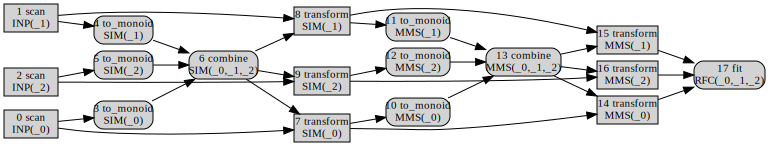

{
    "spill_count": 6,
    "load_count": 6,
    "spill_space": 107200,
    "load_space": 107200,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 9,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.2800436019897461,
    "apply_time": 0.13493752479553223,
    "metric_time": 0,
    "critical_count": 8,
    "critical_time": 0.3055744171142578,
}
accuracy 70.303%


In [6]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline("rfc"), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: pre-trained operator

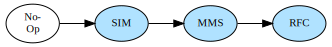

In [7]:
from lale.lib.lale import NoOp

pipeline = NoOp >> fresh_pipeline("rfc")
pipeline.visualize()

spill /tmp/tmpkqoft1_d/X_-1__2_None.pkl /tmp/tmpkqoft1_d/y_-1__2_None.pkl
spill /tmp/tmpkqoft1_d/X_-1__1_None.pkl /tmp/tmpkqoft1_d/y_-1__1_None.pkl
load /tmp/tmpkqoft1_d/X_-1__1_None.pkl /tmp/tmpkqoft1_d/y_-1__1_None.pkl
spill /tmp/tmpkqoft1_d/X_0__0_None.pkl /tmp/tmpkqoft1_d/y_0__0_None.pkl
load /tmp/tmpkqoft1_d/X_-1__2_None.pkl /tmp/tmpkqoft1_d/y_-1__2_None.pkl
load /tmp/tmpkqoft1_d/X_0__0_None.pkl /tmp/tmpkqoft1_d/y_0__0_None.pkl
spill /tmp/tmpkqoft1_d/X_0__2_None.pkl /tmp/tmpkqoft1_d/y_0__2_None.pkl
spill /tmp/tmpkqoft1_d/X_0__1_None.pkl /tmp/tmpkqoft1_d/y_0__1_None.pkl
load /tmp/tmpkqoft1_d/X_0__1_None.pkl /tmp/tmpkqoft1_d/y_0__1_None.pkl
spill /tmp/tmpkqoft1_d/X_1__0_None.pkl /tmp/tmpkqoft1_d/y_1__0_None.pkl
load /tmp/tmpkqoft1_d/X_0__2_None.pkl /tmp/tmpkqoft1_d/y_0__2_None.pkl
load /tmp/tmpkqoft1_d/X_1__0_None.pkl /tmp/tmpkqoft1_d/y_1__0_None.pkl
spill /tmp/tmpkqoft1_d/X_1__2_None.pkl /tmp/tmpkqoft1_d/y_1__2_None.pkl
spill /tmp/tmpkqoft1_d/X_1__1_None.pkl /tmp/tmpkqoft1_d/y_1__1

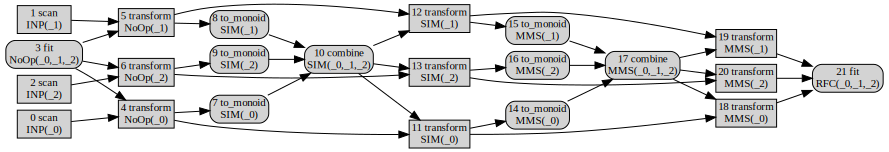

{
    "spill_count": 9,
    "load_count": 9,
    "spill_space": 160800,
    "load_space": 160800,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 10,
    "apply_count": 12,
    "metric_count": 0,
    "train_time": 0.3234100341796875,
    "apply_time": 0.2039797306060791,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.37314295768737793,
}
accuracy 70.303%


In [8]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(pipeline, batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: batching using associativity where possible, partial_fit otherwise
- unlike our batching patent, which always used partial_fit
- behavior still equivalent to sklearn
- potential advantages: less resident data; parallelism
- below are three runs with three different scheduling priorities

spill /tmp/tmpiepesjo8/X_-1__2_None.pkl /tmp/tmpiepesjo8/y_-1__2_None.pkl
spill /tmp/tmpiepesjo8/X_-1__1_None.pkl /tmp/tmpiepesjo8/y_-1__1_None.pkl
load /tmp/tmpiepesjo8/X_-1__1_None.pkl /tmp/tmpiepesjo8/y_-1__1_None.pkl
spill /tmp/tmpiepesjo8/X_0__0_None.pkl /tmp/tmpiepesjo8/y_0__0_None.pkl
load /tmp/tmpiepesjo8/X_-1__2_None.pkl /tmp/tmpiepesjo8/y_-1__2_None.pkl
load /tmp/tmpiepesjo8/X_0__0_None.pkl /tmp/tmpiepesjo8/y_0__0_None.pkl
spill /tmp/tmpiepesjo8/X_0__2_None.pkl /tmp/tmpiepesjo8/y_0__2_None.pkl
spill /tmp/tmpiepesjo8/X_0__1_None.pkl /tmp/tmpiepesjo8/y_0__1_None.pkl
load /tmp/tmpiepesjo8/X_0__1_None.pkl /tmp/tmpiepesjo8/y_0__1_None.pkl
spill /tmp/tmpiepesjo8/X_1__0_None.pkl /tmp/tmpiepesjo8/y_1__0_None.pkl
load /tmp/tmpiepesjo8/X_0__2_None.pkl /tmp/tmpiepesjo8/y_0__2_None.pkl
load /tmp/tmpiepesjo8/X_1__0_None.pkl /tmp/tmpiepesjo8/y_1__0_None.pkl


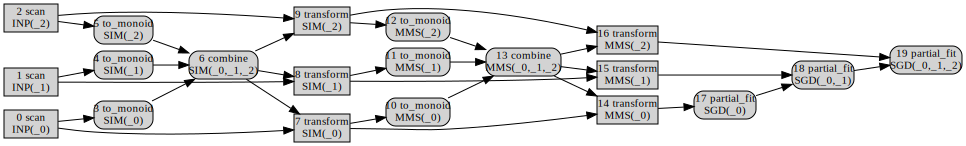

{
    "spill_count": 6,
    "load_count": 6,
    "spill_space": 107200,
    "load_space": 107200,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.11070036888122559,
    "apply_time": 0.19190073013305664,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.1313943862915039,
}
accuracy 62.424%


In [9]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmpdcqfexm5/X_-1__2_None.pkl /tmp/tmpdcqfexm5/y_-1__2_None.pkl
spill /tmp/tmpdcqfexm5/X_-1__1_None.pkl /tmp/tmpdcqfexm5/y_-1__1_None.pkl
load /tmp/tmpdcqfexm5/X_-1__1_None.pkl /tmp/tmpdcqfexm5/y_-1__1_None.pkl
spill /tmp/tmpdcqfexm5/X_0__0_None.pkl /tmp/tmpdcqfexm5/y_0__0_None.pkl
load /tmp/tmpdcqfexm5/X_-1__2_None.pkl /tmp/tmpdcqfexm5/y_-1__2_None.pkl
load /tmp/tmpdcqfexm5/X_0__0_None.pkl /tmp/tmpdcqfexm5/y_0__0_None.pkl
spill /tmp/tmpdcqfexm5/X_0__2_None.pkl /tmp/tmpdcqfexm5/y_0__2_None.pkl
spill /tmp/tmpdcqfexm5/X_0__1_None.pkl /tmp/tmpdcqfexm5/y_0__1_None.pkl
load /tmp/tmpdcqfexm5/X_0__1_None.pkl /tmp/tmpdcqfexm5/y_0__1_None.pkl
load /tmp/tmpdcqfexm5/X_0__2_None.pkl /tmp/tmpdcqfexm5/y_0__2_None.pkl


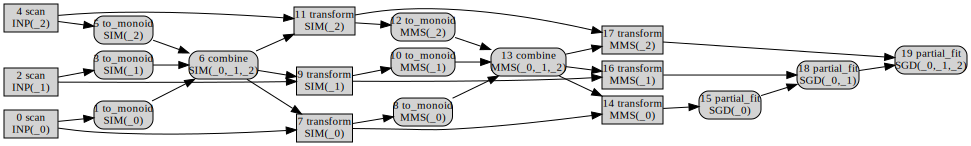

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.10771059989929199,
    "apply_time": 0.2079925537109375,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.13983154296875,
}
accuracy 62.424%


In [10]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioBatch(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmpruyrrmdu/X_-1__2_None.pkl /tmp/tmpruyrrmdu/y_-1__2_None.pkl
spill /tmp/tmpruyrrmdu/X_-1__1_None.pkl /tmp/tmpruyrrmdu/y_-1__1_None.pkl
load /tmp/tmpruyrrmdu/X_-1__1_None.pkl /tmp/tmpruyrrmdu/y_-1__1_None.pkl
spill /tmp/tmpruyrrmdu/X_0__0_None.pkl /tmp/tmpruyrrmdu/y_0__0_None.pkl
load /tmp/tmpruyrrmdu/X_-1__2_None.pkl /tmp/tmpruyrrmdu/y_-1__2_None.pkl
load /tmp/tmpruyrrmdu/X_0__0_None.pkl /tmp/tmpruyrrmdu/y_0__0_None.pkl
spill /tmp/tmpruyrrmdu/X_1__2_None.pkl /tmp/tmpruyrrmdu/y_1__2_None.pkl
load /tmp/tmpruyrrmdu/X_1__2_None.pkl /tmp/tmpruyrrmdu/y_1__2_None.pkl


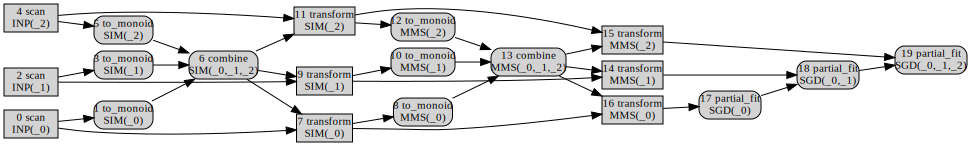

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.12434267997741699,
    "apply_time": 0.15532684326171875,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.14365196228027344,
}
accuracy 62.424%


In [11]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioResourceAware(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: incremental computation, start using transformer before it has seen all data
- behavior not equivalent to sklearn, instead more similar to DL
- but may be "close enough" if operators are "convergent"
- advantage: need much less resident data
- amenable to early stopping, extracting a checkpoint

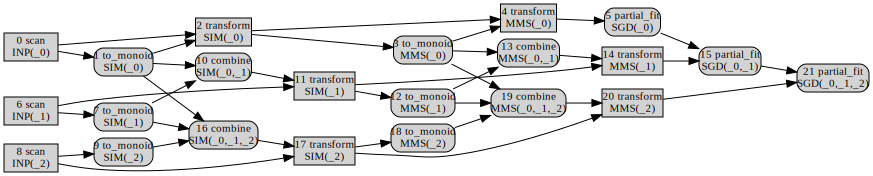

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 13,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.0871880054473877,
    "apply_time": 0.08039546012878418,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.07281231880187988,
}
accuracy 70.303%


In [12]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: learning curve during incremental fit_with_batches

spill /tmp/tmp44db8pjo/X_-1__0_None.pkl /tmp/tmp44db8pjo/y_-1__0_None.pkl
load /tmp/tmp44db8pjo/X_-1__0_None.pkl /tmp/tmp44db8pjo/y_-1__0_None.pkl
callback state 68.750%
spill /tmp/tmp44db8pjo/X_-1__2_None.pkl /tmp/tmp44db8pjo/y_-1__2_None.pkl
callback state 68.750%, 69.955%
load /tmp/tmp44db8pjo/X_-1__2_None.pkl /tmp/tmp44db8pjo/y_-1__2_None.pkl
callback state 68.750%, 69.955%, 71.300%


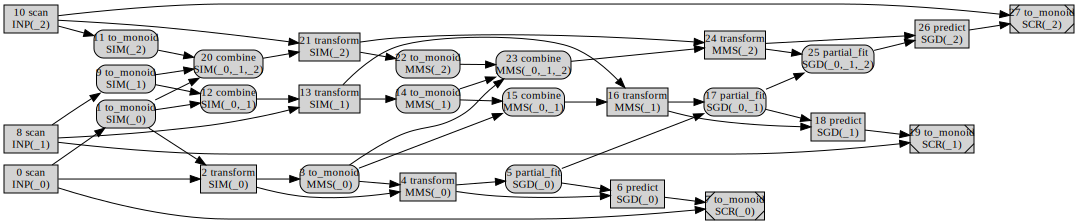

{
    "spill_count": 2,
    "load_count": 2,
    "spill_space": 35760,
    "load_space": 35760,
    "min_resident": 53760,
    "max_resident": 53601,
    "train_count": 13,
    "apply_count": 12,
    "metric_count": 3,
    "train_time": 0.12715840339660645,
    "apply_time": 0.16449594497680664,
    "metric_time": 0.044513702392578125,
    "critical_count": 11,
    "critical_time": 0.12502527236938477,
}
accuracy 70.303%


In [13]:
class DummyCallback:  # ideally, should create a dynamically updating plot in Jupyter
    def __init__(self):
        self.scores = []
    
    def __call__(self, score):
        self.scores.append(score)
        scores_s = ", ".join(f"{s:.3%}" for s in self.scores)
        print(f"callback state {scores_s}")

n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, accuracy_scorer, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=DummyCallback())
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: cross-validation without batching, using same-fold data for training
- behavior equivalent to sklearn
- reuse of lifted coefficients limited to first operator
- disambiguate some tasks by `#~f`, where f is the left-out fold
- using associativity where possible, partial_fit otherwise

spill /tmp/tmp9wcw3qw5/X_-1_d0_None.pkl /tmp/tmp9wcw3qw5/y_-1_d0_None.pkl
spill /tmp/tmp9wcw3qw5/X_-1_e0_None.pkl /tmp/tmp9wcw3qw5/y_-1_e0_None.pkl
spill /tmp/tmp9wcw3qw5/X_0_e0_d.pkl /tmp/tmp9wcw3qw5/y_0_e0_d.pkl
spill /tmp/tmp9wcw3qw5/X_-1_f0_None.pkl /tmp/tmp9wcw3qw5/y_-1_f0_None.pkl
load /tmp/tmp9wcw3qw5/X_0_e0_d.pkl /tmp/tmp9wcw3qw5/y_0_e0_d.pkl
spill /tmp/tmp9wcw3qw5/X_0_f0_e.pkl /tmp/tmp9wcw3qw5/y_0_f0_e.pkl
load /tmp/tmp9wcw3qw5/X_-1_d0_None.pkl /tmp/tmp9wcw3qw5/y_-1_d0_None.pkl
spill /tmp/tmp9wcw3qw5/X_0_f0_f.pkl /tmp/tmp9wcw3qw5/y_0_f0_f.pkl
spill /tmp/tmp9wcw3qw5/X_0_e0_e.pkl /tmp/tmp9wcw3qw5/y_0_e0_e.pkl
spill /tmp/tmp9wcw3qw5/X_0_e0_f.pkl /tmp/tmp9wcw3qw5/y_0_e0_f.pkl
load /tmp/tmp9wcw3qw5/X_0_e0_e.pkl /tmp/tmp9wcw3qw5/y_0_e0_e.pkl
load /tmp/tmp9wcw3qw5/X_0_e0_f.pkl /tmp/tmp9wcw3qw5/y_0_e0_f.pkl
load /tmp/tmp9wcw3qw5/X_0_f0_e.pkl /tmp/tmp9wcw3qw5/y_0_f0_e.pkl
load /tmp/tmp9wcw3qw5/X_-1_e0_None.pkl /tmp/tmp9wcw3qw5/y_-1_e0_None.pkl
load /tmp/tmp9wcw3qw5/X_0_f0_f.pkl /tmp/tm

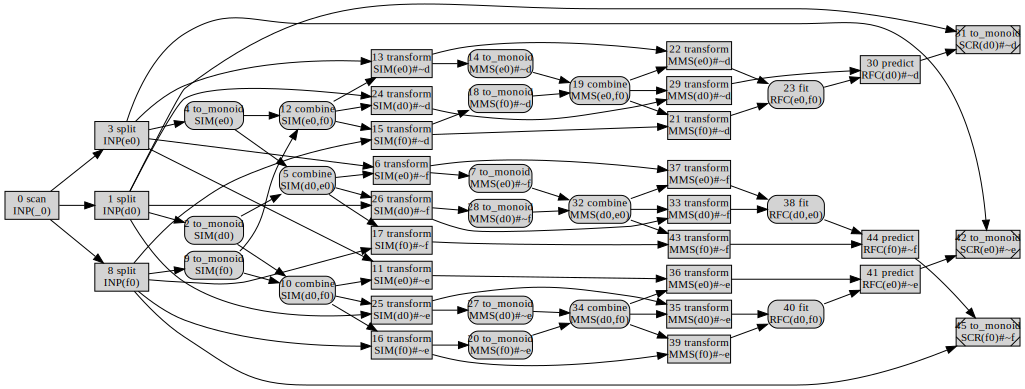

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142800,
    "load_space": 142800,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 25,
    "metric_count": 3,
    "train_time": 1.2805652618408203,
    "apply_time": 0.43246960639953613,
    "metric_time": 0.040528297424316406,
    "critical_count": 11,
    "critical_time": 0.5840263366699219,
}
accuracies 72.768%, 68.161%, 69.507%


In [14]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("rfc"), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with batching, using same-fold data for training
- compared to cross-validation without batching, requires less resident memory

spill /tmp/tmpbd7l1_p2/X_-1__1_None.pkl /tmp/tmpbd7l1_p2/y_-1__1_None.pkl
spill /tmp/tmpbd7l1_p2/X_-1_d0_None.pkl /tmp/tmpbd7l1_p2/y_-1_d0_None.pkl
spill /tmp/tmpbd7l1_p2/X_-1_e0_None.pkl /tmp/tmpbd7l1_p2/y_-1_e0_None.pkl
load /tmp/tmpbd7l1_p2/X_-1__1_None.pkl /tmp/tmpbd7l1_p2/y_-1__1_None.pkl
spill /tmp/tmpbd7l1_p2/X_-1_f0_None.pkl /tmp/tmpbd7l1_p2/y_-1_f0_None.pkl
spill /tmp/tmpbd7l1_p2/X_-1_d1_None.pkl /tmp/tmpbd7l1_p2/y_-1_d1_None.pkl
spill /tmp/tmpbd7l1_p2/X_0_e1_f.pkl /tmp/tmpbd7l1_p2/y_0_e1_f.pkl
spill /tmp/tmpbd7l1_p2/X_0_f1_f.pkl /tmp/tmpbd7l1_p2/y_0_f1_f.pkl
spill /tmp/tmpbd7l1_p2/X_-1_f1_None.pkl /tmp/tmpbd7l1_p2/y_-1_f1_None.pkl
load /tmp/tmpbd7l1_p2/X_-1_f0_None.pkl /tmp/tmpbd7l1_p2/y_-1_f0_None.pkl
spill /tmp/tmpbd7l1_p2/X_0_f1_d.pkl /tmp/tmpbd7l1_p2/y_0_f1_d.pkl
spill /tmp/tmpbd7l1_p2/X_0_f1_e.pkl /tmp/tmpbd7l1_p2/y_0_f1_e.pkl
spill /tmp/tmpbd7l1_p2/X_-1_e1_None.pkl /tmp/tmpbd7l1_p2/y_-1_e1_None.pkl
spill /tmp/tmpbd7l1_p2/X_-1_f0_None.pkl /tmp/tmpbd7l1_p2/y_-1_f0_None.pk

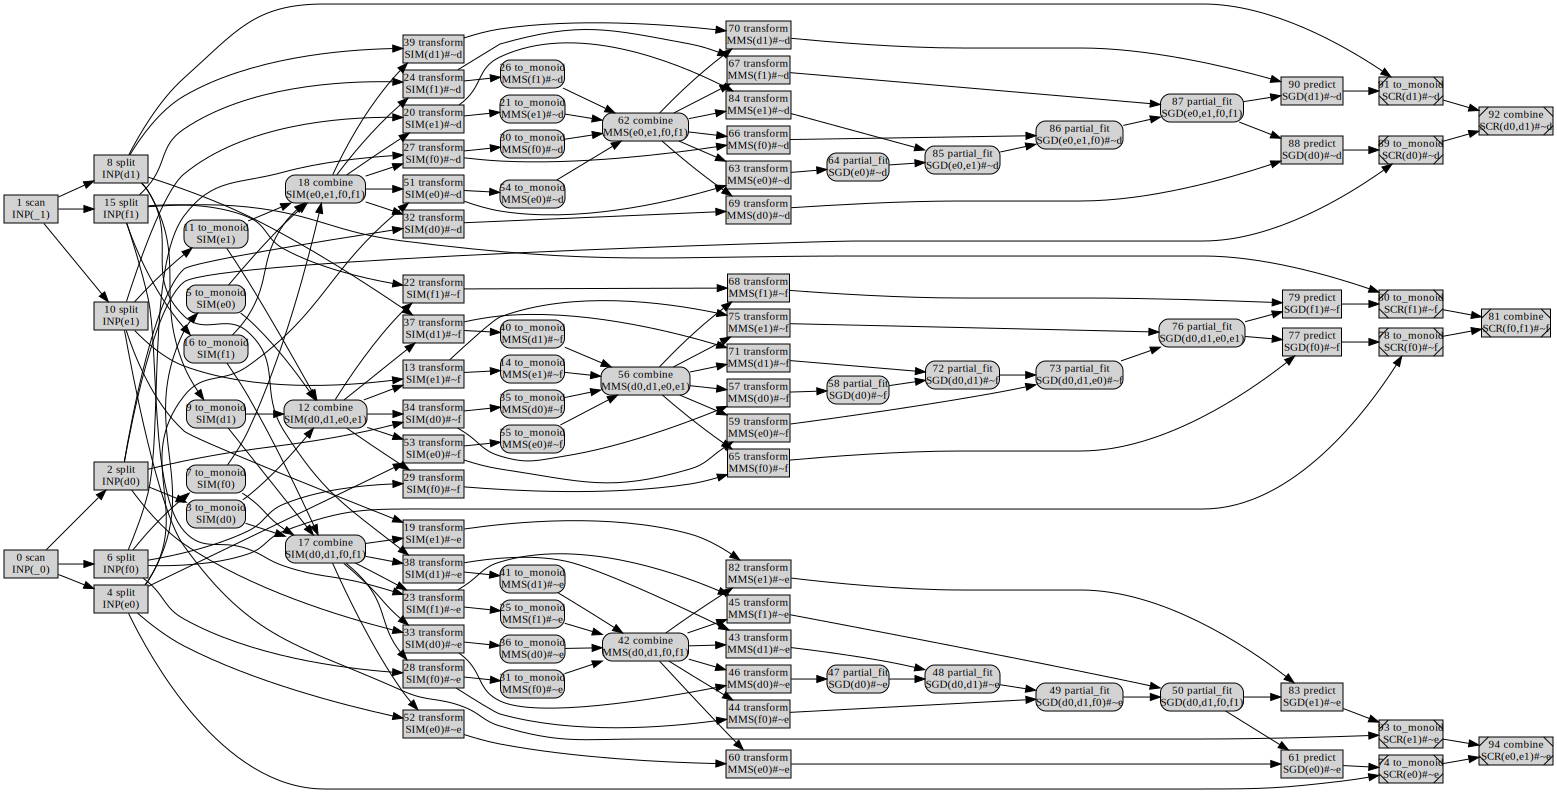

{
    "spill_count": 29,
    "load_count": 29,
    "spill_space": 276640,
    "load_space": 276640,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 36,
    "apply_count": 50,
    "metric_count": 9,
    "train_time": 0.6022751331329346,
    "apply_time": 2.135770082473755,
    "metric_time": 0.3773941993713379,
    "critical_count": 15,
    "critical_time": 0.6467640399932861,
}
accuracies 68.304%, 73.661%, 63.964%


In [15]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with out-of-fold samples
- not sklearn compatible
- might generalize better by following best practices for stacking ensembles
- depends on transformers being convergent
- fewer tasks overall than for cross-validation with in-fold samples

spill /tmp/tmpxnq0_rfk/X_-1_d0_None.pkl /tmp/tmpxnq0_rfk/y_-1_d0_None.pkl
spill /tmp/tmpxnq0_rfk/X_0_f0_e.pkl /tmp/tmpxnq0_rfk/y_0_f0_e.pkl
spill /tmp/tmpxnq0_rfk/X_-1_f0_None.pkl /tmp/tmpxnq0_rfk/y_-1_f0_None.pkl
load /tmp/tmpxnq0_rfk/X_-1_d0_None.pkl /tmp/tmpxnq0_rfk/y_-1_d0_None.pkl
spill /tmp/tmpxnq0_rfk/X_0_f0_f.pkl /tmp/tmpxnq0_rfk/y_0_f0_f.pkl
spill /tmp/tmpxnq0_rfk/X_-1_e0_None.pkl /tmp/tmpxnq0_rfk/y_-1_e0_None.pkl
load /tmp/tmpxnq0_rfk/X_-1_e0_None.pkl /tmp/tmpxnq0_rfk/y_-1_e0_None.pkl
load /tmp/tmpxnq0_rfk/X_0_f0_f.pkl /tmp/tmpxnq0_rfk/y_0_f0_f.pkl
load /tmp/tmpxnq0_rfk/X_0_f0_e.pkl /tmp/tmpxnq0_rfk/y_0_f0_e.pkl
load /tmp/tmpxnq0_rfk/X_-1_f0_None.pkl /tmp/tmpxnq0_rfk/y_-1_f0_None.pkl


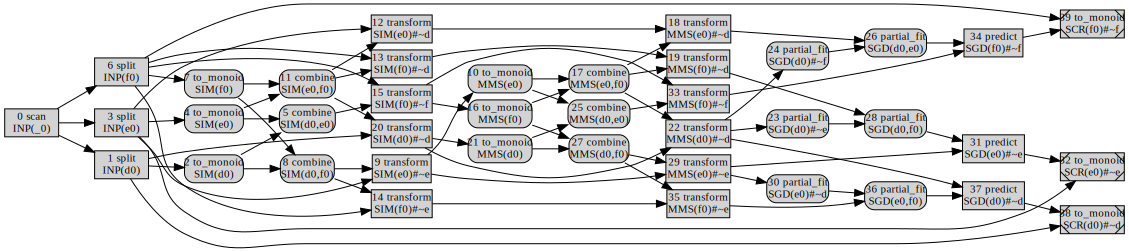

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 19,
    "metric_count": 3,
    "train_time": 0.13440680503845215,
    "apply_time": 0.27725648880004883,
    "metric_time": 0.04797506332397461,
    "critical_count": 12,
    "critical_time": 0.13960623741149902,
}
accuracies 69.643%, 69.507%, 70.852%


In [16]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

spill /tmp/tmph0s2ws4w/X_-1__1_None.pkl /tmp/tmph0s2ws4w/y_-1__1_None.pkl
spill /tmp/tmph0s2ws4w/X_-1_d0_None.pkl /tmp/tmph0s2ws4w/y_-1_d0_None.pkl
spill /tmp/tmph0s2ws4w/X_-1_e0_None.pkl /tmp/tmph0s2ws4w/y_-1_e0_None.pkl
load /tmp/tmph0s2ws4w/X_-1__1_None.pkl /tmp/tmph0s2ws4w/y_-1__1_None.pkl
spill /tmp/tmph0s2ws4w/X_-1_f0_None.pkl /tmp/tmph0s2ws4w/y_-1_f0_None.pkl
spill /tmp/tmph0s2ws4w/X_-1_d1_None.pkl /tmp/tmph0s2ws4w/y_-1_d1_None.pkl
spill /tmp/tmph0s2ws4w/X_0_f1_e.pkl /tmp/tmph0s2ws4w/y_0_f1_e.pkl
spill /tmp/tmph0s2ws4w/X_-1_f1_None.pkl /tmp/tmph0s2ws4w/y_-1_f1_None.pkl
load /tmp/tmph0s2ws4w/X_-1_f0_None.pkl /tmp/tmph0s2ws4w/y_-1_f0_None.pkl
spill /tmp/tmph0s2ws4w/X_0_f1_d.pkl /tmp/tmph0s2ws4w/y_0_f1_d.pkl
spill /tmp/tmph0s2ws4w/X_0_f1_f.pkl /tmp/tmph0s2ws4w/y_0_f1_f.pkl
spill /tmp/tmph0s2ws4w/X_0_f0_e.pkl /tmp/tmph0s2ws4w/y_0_f0_e.pkl
spill /tmp/tmph0s2ws4w/X_-1_f0_None.pkl /tmp/tmph0s2ws4w/y_-1_f0_None.pkl
load /tmp/tmph0s2ws4w/X_-1_d0_None.pkl /tmp/tmph0s2ws4w/y_-1_d0_None.pkl

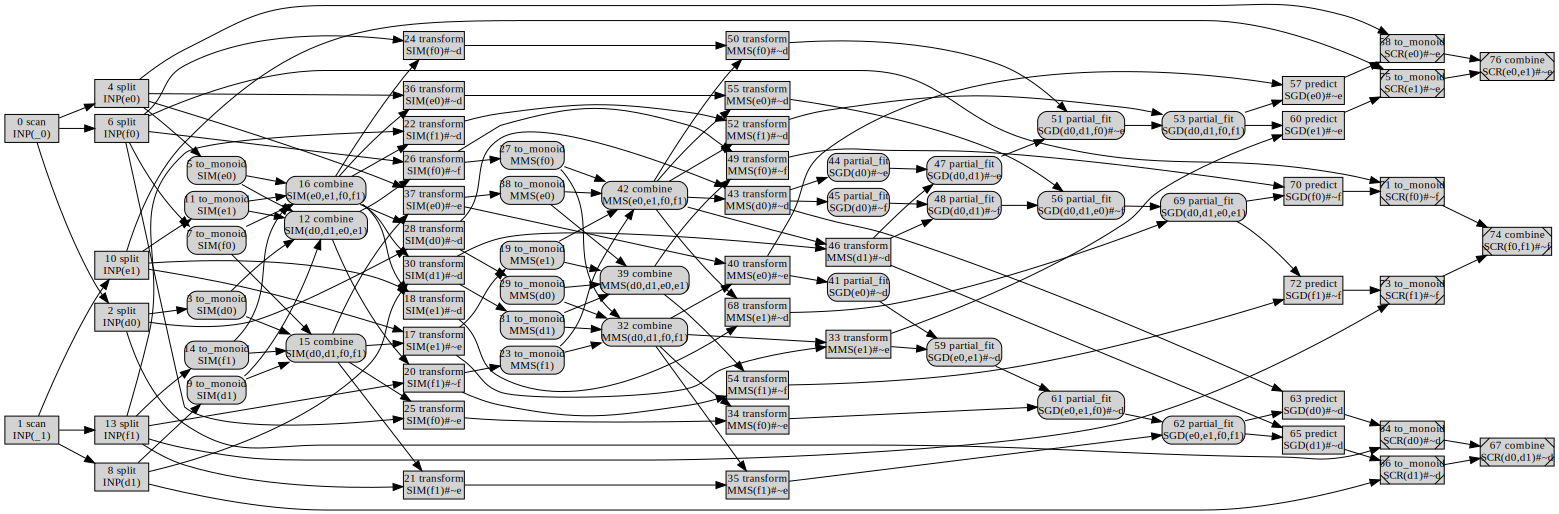

{
    "spill_count": 24,
    "load_count": 24,
    "spill_space": 231840,
    "load_space": 231840,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 30,
    "apply_count": 38,
    "metric_count": 9,
    "train_time": 0.3042333126068115,
    "apply_time": 0.6682074069976807,
    "metric_time": 0.07120752334594727,
    "critical_count": 15,
    "critical_time": 0.1778106689453125,
}
accuracies 68.304%, 75.000%, 66.216%


In [17]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))